In [1]:
# importing important libraries requiered for our project

import numpy as np
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn import preprocessing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,classification_report

In [2]:
# loading dataset into the program
data = pd.read_csv('SMSCollection.csv', encoding = 'ISO-8859-1')

In [3]:
#checking data
data.head()

,Type,Message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Type     5571 non-null   object
 1   Message  5571 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
data.shape

(5571, 2)

## Data Cleaning

In [6]:
# checking null values - no null values
data.isna().sum()

Type       0
Message    0
dtype: int64

In [7]:
# checking duplicate values
data.duplicated().sum()

403

In [8]:
# removing duplicate values
data = data.drop_duplicates(keep = 'first')

In [9]:
data.duplicated().sum()

0

In [10]:
data.shape

(5168, 2)

In [11]:
# checking unique values in Type column
data['Type'].unique()

array(['ham', 'spam'], dtype=object)

In [12]:
# encoding the categories
le = preprocessing.LabelEncoder() 
le.fit(['ham', 'spam'])
data['Type'] = le.fit_transform(data['Type'])

In [13]:
data['Type'].unique()

array([0, 1])

## EDA

In [14]:
#checking value counts for the need of bagging
data['Type'].value_counts()

Type
0    4515
1     653
Name: count, dtype: int64

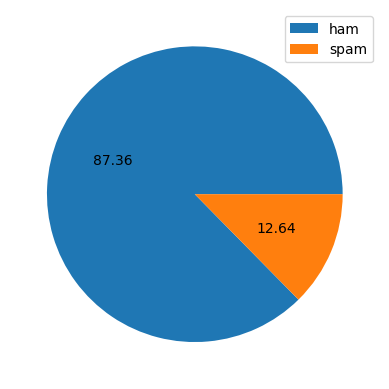

In [15]:
# checking the imbalance through pie chart
plt.pie(data['Type'].value_counts(), autopct= '%0.2f')
l = ['ham', 'spam']
plt.legend(l)
plt.show()

In [16]:
# column for len of the message
data['num_of_char'] = data['Message'].apply(len)

In [17]:
# column for number of words
data['num_of_words'] = data['Message'].apply(lambda x: len(nltk.word_tokenize(x)))

In [18]:
data.head()

,Type,Message,num_of_char,num_of_words
0,0,Ok lar... Joking wif u oni...,29,8
1,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
2,0,U dun say so early hor... U c already then say...,49,13
3,0,"Nah I don't think he goes to usf, he lives aro...",61,15
4,1,FreeMsg Hey there darling it's been 3 week's n...,147,39


In [19]:
# checking values for ham
data[data['Type'] ==0 ][['num_of_char', 'num_of_words']].describe()

,num_of_char,num_of_words
count,4515.000000,4515.000000
mean,70.896567,17.265338
std,56.717589,13.599859
min,2.000000,1.000000
25%,34.000000,8.000000
50%,53.000000,13.000000
75%,91.000000,22.000000
max,910.000000,220.000000


In [20]:
# checking values for spam
data[data['Type'] ==1 ][['num_of_char', 'num_of_words']].describe()

,num_of_char,num_of_words
count,653.000000,653.000000
mean,137.704441,27.761103
std,29.821348,6.993504
min,13.000000,2.000000
25%,132.000000,25.000000
50%,148.000000,29.000000
75%,157.000000,32.000000
max,223.000000,46.000000


In [21]:
# comparing the ham and spam messages through histograms
from cProfile import label

sns.histplot(data[data['Type'] == 0]['num_of_char'], color = 'green', label = 'ham')
sns.histplot(data[data['Type'] == 1]['num_of_char'], color = 'red', label = 'spam')
plt.legend()

# conclusion - spam messages are made with more number of characters than ham messages

NameError: name 'sns' is not defined

In [ ]:
sns.histplot(data[data['Type'] == 0]['num_of_words'], color = 'green', label = 'ham')
sns.histplot(data[data['Type'] == 1]['num_of_words'], color = 'red', label = 'spam')
plt.legend()
# conclusion - spam messages are made with more number of words than ham messages

## Text Preprocessing

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# function to extract words
def extracting_words(message):
    # typecast message to string - error is shown otherwise
    message = str(message)
    #Tokenizing message
    message  = message.lower()
    words = nltk.word_tokenize(message)

    # keeping alpha numeric values
    words = [w for w in words if w.isalnum()]
    
    # removing stopwords and punctuations
    en_stops = set(stopwords.words('english'))
    en_punc = set(string.punctuation)
    words = [w for w in words if w not in en_stops and w not in en_punc]
    
    #stemming
    for j in range(len(words)):
        stemmer = PorterStemmer()
        words[j] = stemmer.stem(words[j])
        
    return ' '.join(words)

In [24]:
# applying the above function on the dataset and making new column for the output named Extracted_mess
data['Extracted_mess'] = data['Message'].apply(extracting_words)

In [25]:
data.head(3)

,Type,Message,num_of_char,num_of_words,Extracted_mess
0,0,Ok lar... Joking wif u oni...,29,8,ok lar joke wif u oni
1,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,free entri 2 wkli comp win fa cup final tkt 21...
2,0,U dun say so early hor... U c already then say...,49,13,u dun say earli hor u c alreadi say


In [26]:
# setting target and features
target = data['Type']
feature = data['Extracted_mess'].values
feature.shape, target.shape

((5168,), (5168,))

In [27]:
# visualization of the word cloud of spam and ham
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='black')

ModuleNotFoundError: No module named 'wordcloud'

In [28]:
fig = plt.figure(figsize=(5,5))
spam_wc = wc.generate(data[data['Type'] == 1]['Extracted_mess'].str.cat(sep=' '))
plt.imshow(spam_wc)

NameError: name 'wc' is not defined

<Figure size 500x500 with 0 Axes>

In [29]:
fig = plt.figure(figsize=(5,5))
ham_wc = wc.generate(data[data['Type'] == 0]['Extracted_mess'].str.cat(sep=' '))
plt.imshow(ham_wc)

NameError: name 'wc' is not defined

<Figure size 500x500 with 0 Axes>

In [30]:
# making barplot for top 30 words used in spam messages
spam_list = []
for msg in data[data['Type'] == 1]['Extracted_mess'].tolist():
    for word in msg.split():
        spam_list.append(word)

In [31]:
len(spam_list)

9981

In [32]:
# top 30 words in spam messages
from collections import Counter
sns.barplot(pd.DataFrame(Counter(spam_list).most_common(30))[0],pd.DataFrame(Counter(spam_list).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

NameError: name 'sns' is not defined

In [33]:
# making barplot for top 30 words in ham messages
ham_list = []
for msg in data[data['Type'] == 0]['Extracted_mess'].tolist():
    for word in msg.split():
        ham_list.append(word)

In [34]:
len(ham_list)

35937

In [35]:
sns.barplot(pd.DataFrame(Counter(ham_list).most_common(30))[0],pd.DataFrame(Counter(ham_list).most_common(30))[1])
plt.xticks(rotation = 'vertical')
plt.show()

NameError: name 'sns' is not defined

## Building Model

In [94]:
# vectorizing the extracted words using TF-IFD
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(feature)
X2 = vectorizer.fit(feature)
X2 = vectorizer.transform(feature).toarray()

In [37]:
X.shape

(5168, 6790)

### Using RandomForestClassifier

In [38]:
# specifying model
bag_model = RandomForestClassifier()

In [84]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X2, target, test_size = 0.25, random_state=42)

In [85]:
bag_model.fit(X_train, y_train)

RandomForestClassifier()

In [86]:
train_pred = bag_model.predict(X_train)
pred = bag_model.predict(X_test)

In [87]:
# accuracy of the model
print(accuracy_score(y_train, train_pred))
print(accuracy_score(y_test, pred))
print(precision_score(y_test, pred))

1.0
0.9705882352941176
1.0


In [43]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1129
           1       0.99      0.77      0.87       163

    accuracy                           0.97      1292
   macro avg       0.98      0.88      0.92      1292
weighted avg       0.97      0.97      0.97      1292

[[1128    1]
 [  38  125]]


### Using Naive Bayes

In [44]:
# specifying the model
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X2, target, test_size = 0.25)

In [46]:
# testing the accuracy and precision for GaussianNB
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8792569659442725
0.5129151291512916


In [47]:
# testing the accuracy and precision for MultinomialNB
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9520123839009288
1.0


In [48]:
# testing the accuracy and precision for BernoulliNB
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9628482972136223
0.9389312977099237


In [49]:
import joblib

In [82]:
import pickle

In [83]:
filename = 'finalized_model.sav'
pickle.dump(bnb, open(filename, 'wb'))

In [77]:
# making a pickel file to store trained model and vectorizer
joblib.dump(mnb, 'Model_mnb.pkl')

['Model_mnb.pkl']

In [95]:
joblib.dump(vectorizer, 'Vector.pkl')

['Vector.pkl']

In [88]:
mnb_model = joblib.load('Model_mnb.pkl')
tf = joblib.load('Vector.pkl')

In [91]:
data = ['free tickets']

In [92]:
vect =  tf.transform(data).toarray()
my_pred = bag_model.predict(vect)

In [93]:
my_pred

array([0])